# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [7]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [8]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [9]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     300.1
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          1.69e-197
Time:                        15:55:05   Log-Likelihood:                -377.51
No. Observations:                 774   AIC:                             767.0
Df Residuals:                     768   BIC:                             794.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0152      0.001     10.971      0.000       0.012       0.018
DEP_DELAY              -0.0033      0.001     -3.876      0.000      -0.005      -0.002
CRS_ARR_TIME            0.0094      0.001      6.422      0.000       0.007       0.012
CARRIER_DELAY           0.0062      0.001      6.425      0.000       0.004       0.008
NAS_DELAY               0.0130      0.001     15.778      0.000       0.011       0.015
LATE_AIRCRAFT_DELAY     0.0107      0.001      9.248      0.000       0.008       0.013
==============================================================================
Omnibus:                        7.372   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.741
Skew:                          -0.180   Prob(JB):                       0.0208
Kurtosis:                       3.331   Cond. No.                         8.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


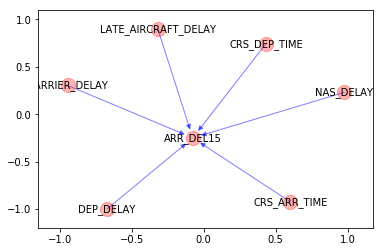

In [10]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [11]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     153.5
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          8.64e-165
Time:                        15:55:05   Log-Likelihood:                -3064.5
No. Observations:                 774   AIC:                             6147.
Df Residuals:                     765   BIC:                             6189.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.9872      0.413     -4.808      0.000      -2.798      -1.176
CRS_DEP_TIME           -0.6542      0.067     -9.726      0.000      -0.786      -0.522
DEP_DELAY               0.6704      0.027     24.805      0.000       0.617       0.723
TAXI_OUT                0.8390      0.044     19.254      0.000       0.753       0.925
TAXI_IN                 0.8482      0.053     16.145      0.000       0.745       0.951
CRS_ARR_TIME           -0.7332      0.076     -9.693      0.000      -0.882      -0.585
DIVERTED            -1.623e-16   1.83e-17     -8.878      0.000   -1.98e-16   -1.26e-16
CARRIER_DELAY          -0.6837      0.030    -22.764      0.000      -0.743      -0.625
WEATHER_DELAY          -0.6144      0.080     -7.640      0.000      -0.772      -0.457
LATE_AIRCRAFT_DELAY    -0.7217      0.036    -20.127      0.000      -0.792      -0.651
==============================================================================
Omnibus:                      134.433   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.639
Skew:                           0.934   Prob(JB):                     7.84e-69
Kurtosis:                       5.497   Cond. No.                     1.30e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


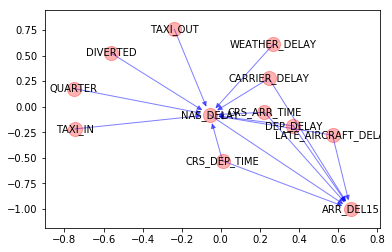

In [13]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [14]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.786
Model:                             OLS   Adj. R-squared:                  0.785
Method:                  Least Squares   F-statistic:                     566.0
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          7.51e-255
Time:                         15:55:06   Log-Likelihood:                -2997.8
No. Observations:                  774   AIC:                             6006.
Df Residuals:                      769   BIC:                             6029.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.3326      0.061      5.495      0.000       0.214       0.451
DEP_DELAY         0.6621      0.013     49.607      0.000       0.636       0.688
CARRIER_DELAY    -0.6749      0.018    -36.874      0.000      -0.711      -0.639
WEATHER_DELAY    -0.6741      0.071     -9.539      0.000      -0.813      -0.535
NAS_DELAY        -0.2916      0.022    -13.189      0.000      -0.335      -0.248
==============================================================================
Omnibus:                      242.415   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7274.793
Skew:                          -0.763   Prob(JB):                         0.00
Kurtosis:                      17.941   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [16]:
# remove both edges
flight_edges_df, _ = remove_edge('NAS_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [17]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     875.2
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:55:06   Log-Likelihood:                -3010.5
No. Observations:                 774   AIC:                             6037.
Df Residuals:                     766   BIC:                             6074.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.6080      0.060    -10.217      0.000      -0.725      -0.491
DEP_DELAY               0.8830      0.011     81.332      0.000       0.862       0.904
TAXI_OUT                0.5885      0.042     13.993      0.000       0.506       0.671
TAXI_IN                 0.5899      0.052     11.398      0.000       0.488       0.692
CRS_ARR_TIME           -0.7740      0.066    -11.746      0.000      -0.903      -0.645
DIVERTED             3.061e-16   2.95e-17     10.383      0.000    2.48e-16    3.64e-16
WEATHER_DELAY          -0.8379      0.072    -11.700      0.000      -0.978      -0.697
NAS_DELAY              -0.5817      0.026    -22.636      0.000      -0.632      -0.531
LATE_AIRCRAFT_DELAY    -0.9593      0.022    -43.093      0.000      -1.003      -0.916
==============================================================================
Omnibus:                      179.923   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6758.220
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                      17.474   Cond. No.                     4.92e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [19]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]
[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [20]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [21]:
weather_delay_from = ['CRS_DEP_TIME']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.842
Date:                Thu, 29 Mar 2018   Prob (F-statistic):             0.0922
Time:                        15:55:06   Log-Likelihood:                -2489.3
No. Observations:                 774   AIC:                             4981.
Df Residuals:                     773   BIC:                             4985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.0244      0.014      1.686      0.092      -0.004       0.053
==============================================================================
Omnibus:                     2019.350   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18119606.529
Skew:                          27.218   Prob(JB):                         0.00
Kurtosis:                     750.586   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Security Delay

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [23]:
security_delay_from = ['DAY_OF_WEEK','DEP_DELAY','TAXI_OUT','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(security_delay_from, 'SECURITY_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.142
Date:                Thu, 29 Mar 2018   Prob (F-statistic):            0.00475
Time:                        15:55:06   Log-Likelihood:                -1644.0
No. Observations:                 774   AIC:                             3300.
Df Residuals:                     768   BIC:                             3328.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
DAY_OF_WEEK            -0.0647      0.031     -2.104      0.036      -0.125      -0.004
DEP_DELAY               0.0171      0.005      3.678      0.000       0.008       0.026
TAXI_OUT                0.0114      0.005      2.381      0.018       0.002       0.021
CARRIER_DELAY          -0.0179      0.005     -3.459      0.001      -0.028      -0.008
NAS_DELAY              -0.0115      0.005     -2.462      0.014      -0.021      -0.002
LATE_AIRCRAFT_DELAY    -0.0141      0.006     -2.296      0.022      -0.026      -0.002
==============================================================================
Omnibus:                     2007.618   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17489766.205
Skew:                          26.823   Prob(JB):                         0.00
Kurtosis:                     737.466   Cond. No.                         27.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(security_delay_from, 'SECURITY_DELAY',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [25]:
quarter_from = ['MONTH','CRS_DEP_TIME','CRS_ARR_TIME']
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.708e+04
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:55:06   Log-Likelihood:                -105.57
No. Observations:                 774   AIC:                             217.1
Df Residuals:                     771   BIC:                             231.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3233      0.003    112.585      0.000       0.318       0.329
CRS_DEP_TIME     0.0102      0.001      8.564      0.000       0.008       0.013
CRS_ARR_TIME     0.0180      0.001     14.916      0.000       0.016       0.020
==============================================================================
Omnibus:                      909.134   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.742
Skew:                           0.071   Prob(JB):                     5.81e-12
Kurtosis:                       1.741   Cond. No.                         6.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [27]:
departure_delay_from = ['QUARTER','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1272.
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:55:06   Log-Likelihood:                -3054.3
No. Observations:                 774   AIC:                             6131.
Df Residuals:                     763   BIC:                             6182.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 4.0377      1.646      2.453      0.014       0.806       7.269
MONTH                  -1.1054      0.547     -2.021      0.044      -2.179      -0.032
DAY_OF_WEEK             0.6832      0.221      3.086      0.002       0.249       1.118
CRS_DEP_TIME            0.5833      0.070      8.283      0.000       0.445       0.722
TAXI_OUT               -0.7251      0.045    -15.943      0.000      -0.814      -0.636
TAXI_IN                -0.6928      0.055    -12.632      0.000      -0.800      -0.585
CRS_ARR_TIME            0.7669      0.080      9.533      0.000       0.609       0.925
DIVERTED            -1.225e-15   4.69e-16     -2.613      0.009   -2.14e-15   -3.05e-16
CARRIER_DELAY           1.0146      0.012     82.154      0.000       0.990       1.039
WEATHER_DELAY           0.9566      0.075     12.681      0.000       0.809       1.105
NAS_DELAY               0.6628      0.027     24.849      0.000       0.610       0.715
LATE_AIRCRAFT_DELAY     1.0944      0.020     55.495      0.000       1.056       1.133
==============================================================================
Omnibus:                      241.624   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1737.525
Skew:                           1.212   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                     2.76e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


It is not very likely that an NAS-related delay causes a security-related delay. Therefore, we will remove the edge from NAS_DELAY to SECURITY_DELAY.

In [29]:
flight_edges_df, bn = remove_edge('NAS_DELAY','SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [30]:
flight_edges_df, bn = remove_edge('NAS_DELAY','DEP_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Departure delay cannot lead to a late aircraft delay: this is temporally impossible, so we get rid of that directed edge.

In [31]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


Again, temporally, departure delay cannot lead to a carrier delay. Therefore, we remove that directed edge.

In [32]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.


By the same reasoning as above, we remove the edge from DEP_DELAY to SECURITY_DELAY.

In [33]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'SECURITY_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [34]:
taxi_out_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     948.4
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:55:06   Log-Likelihood:                -2767.2
No. Observations:                 774   AIC:                             5552.
Df Residuals:                     765   BIC:                             5594.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 2.4052      0.272      8.839      0.000       1.871       2.939
CRS_DEP_TIME            0.7779      0.040     19.656      0.000       0.700       0.856
DEP_DELAY              -0.3418      0.021    -15.963      0.000      -0.384      -0.300
TAXI_IN                -0.3821      0.039     -9.784      0.000      -0.459      -0.305
CRS_ARR_TIME            0.9085      0.044     20.843      0.000       0.823       0.994
CARRIER_DELAY           0.3318      0.024     14.048      0.000       0.285       0.378
WEATHER_DELAY           0.2590      0.056      4.622      0.000       0.149       0.369
NAS_DELAY               0.3891      0.020     19.254      0.000       0.349       0.429
LATE_AIRCRAFT_DELAY     0.3250      0.028     11.683      0.000       0.270       0.380
==============================================================================
Omnibus:                       35.299   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.600
Skew:                           0.443   Prob(JB):                     2.07e-10
Kurtosis:                       3.772   Cond. No.                         57.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [38]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'SECURITY_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [39]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'NAS_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [40]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [41]:
taxi_in_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     129.7
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          2.06e-147
Time:                        15:55:06   Log-Likelihood:                -2661.8
No. Observations:                 774   AIC:                             5342.
Df Residuals:                     765   BIC:                             5384.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 1.0930      0.246      4.440      0.000       0.610       1.576
CRS_DEP_TIME            0.3573      0.040      8.852      0.000       0.278       0.436
DEP_DELAY              -0.2451      0.020    -12.459      0.000      -0.284      -0.206
TAXI_OUT               -0.2910      0.030     -9.784      0.000      -0.349      -0.233
CRS_ARR_TIME            0.4957      0.044     11.231      0.000       0.409       0.582
DIVERTED             1.787e-15   2.39e-16      7.478      0.000    1.32e-15    2.26e-15
CARRIER_DELAY           0.2478      0.021     11.626      0.000       0.206       0.290
WEATHER_DELAY           0.2152      0.049      4.394      0.000       0.119       0.311
NAS_DELAY               0.2996      0.019     16.145      0.000       0.263       0.336
LATE_AIRCRAFT_DELAY     0.2638      0.025     10.735      0.000       0.216       0.312
==============================================================================
Omnibus:                     1029.270   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           315171.342
Skew:                           6.681   Prob(JB):                         0.00
Kurtosis:                     100.950   Cond. No.                     1.52e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_OUT','DEP_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_IN','NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [45]:
flight_edges_df, bn = remove_edge('TAXI_IN','CARRIER_DELAY', flight_edges_df)

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [46]:
flight_edges_df, bn = remove_edge('TAXI_IN','DEP_DELAY', flight_edges_df)

[('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'TAXI_OUT')]


In [47]:
flight_edges_df, bn = remove_edge('TAXI_IN','TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [48]:
delayed_SFO_from = ['WEATHER_DELAY','ScheduledDepartureSFO','DelayedArrivalPHL','ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.733
Model:                             OLS   Adj. R-squared:                  0.732
Method:                  Least Squares   F-statistic:                     529.0
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          3.44e-219
Time:                         15:55:06   Log-Likelihood:                -1648.5
No. Observations:                  774   AIC:                             3305.
Df Residuals:                      770   BIC:                             3324.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WEATHER_DELAY             0.0245      0.012      1.967      0.050    4.65e-05       0.049
ScheduledDepartureSFO     0.1459      0.004     32.758      0.000       0.137       0.155
DelayedArrivalPHL         0.4437      0.044     10.025      0.000       0.357       0.531
ScheduledArrivalPHL      -0.0543      0.013     -4.103      0.000      -0.080      -0.028
==============================================================================
Omnibus:                      186.563   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              833.188
Skew:                           1.036   Prob(JB):                    1.19e-181
Kurtosis:                       7.641   Cond. No.                         13.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [50]:
delayed_PHL_from = ['CRS_DEP_TIME','WEATHER_DELAY','DelayedDepartureSFO','ScheduledDepartureSFO','ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     618.6
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          1.30e-266
Time:                        15:55:06   Log-Likelihood:                -1438.0
No. Observations:                 774   AIC:                             2886.
Df Residuals:                     769   BIC:                             2909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME             -0.0127      0.004     -2.827      0.005      -0.022      -0.004
WEATHER_DELAY             0.0487      0.009      5.193      0.000       0.030       0.067
DelayedDepartureSFO       0.2574      0.026      9.956      0.000       0.207       0.308
ScheduledDepartureSFO    -0.0475      0.005     -9.406      0.000      -0.057      -0.038
ScheduledArrivalPHL       0.2435      0.006     41.377      0.000       0.232       0.255
==============================================================================
Omnibus:                      444.886   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6425.036
Skew:                           2.289   Prob(JB):                         0.00
Kurtosis:                      16.351   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('DelayedDepartureSFO', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'DelayedDepartureSFO')]


In [52]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL','DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


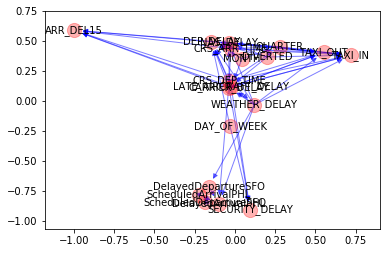

In [53]:
draw_graph(flight_edges_df,'final_bn.png')

In [54]:
nx.is_directed_acyclic_graph(bn), nx.is_tree(bn)

(True, False)

There are 19 nodes and 59 directed edges in this DAG.

## Graph Visualization

In [55]:
from IPython.display import Javascript
import json